In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Importing and Merging Data

In [138]:
electricity = pd.read_csv('../cleaned_datasets/cleaned_electricity.csv')
emissions = pd.read_csv('../cleaned_datasets/cleaned_emissions.csv')
net_gen = pd.read_csv('../cleaned_datasets/cleaned_net_gen.csv')
urbanization = pd.read_csv('../cleaned_datasets/cleaned_urbanization.csv')
weather = pd.read_csv('../cleaned_datasets/cleaned_weather.csv')
plants = pd.read_csv('../cleaned_datasets/cleaned_plants.csv')
state_size = pd.read_csv('../cleaned_datasets/cleaned_statesizes.csv')
consumption = pd.read_csv('../cleaned_datasets/cleaned_consumption.csv')

In [141]:
net_gen = net_gen.rename(columns={'state':'State'})
weather = weather.rename(columns={'state':'State'})
state_size = state_size.rename(columns={'Unnamed: 0':'State'})
consumption = consumption.rename(columns={'state':'State'})

In [142]:
total = pd.merge(electricity, emissions, on='State').drop(columns=[' Year', '2023'])
total = pd.merge(total, net_gen, on='State')
total = pd.merge(total, urbanization, on='State')
total = pd.merge(total, weather, on='State')
total = pd.merge(total, plants, on='State')
total = pd.merge(total, state_size, on='State')
total = pd.merge(total, consumption, on='State')

total = total.rename(columns={
    '2022': 'Electricity Price (cents/kWh)',
    'Emissions': 'CO2 (lb/MWh)',
    'total renewable production': 'total renewable prod (thousand MWh)',
    'total nonrenewable production': 'total nonrenewable prod (thousand MWh)',
    'total production': 'total production (thousand MWh)',
    'total area in sq miles': 'total area (mile^2)'
})
total.head()

,State,Electricity Price (cents/kWh),CO2 (lb/MWh),total renewable prod (thousand MWh),total nonrenewable prod (thousand MWh),total production (thousand MWh),Urban Population,Urban Population (%),avg annual temp (F),avg annual precip (in),avg annual sunlight (kJ/m^2),num_plants,num_renewable,num_nonrenewable,total area (mile^2),water percentage,total consumption
0,Maine,17.44,336.612,8794,4736,13530,526309.0,38.6,41.0,45.5,3815.0,196,170,26,"35,380",12.80%,35399
1,Massachusetts,21.27,851.739,8917,17462,26379,6416895.0,91.3,47.9,48.6,3944.0,632,555,78,"10,554",26.10%,131292
2,New Hampshire,21.07,302.928,2784,16224,19008,803420.0,58.3,43.8,47.9,3891.0,60,38,22,"9,349",4.20%,33311
3,Rhode Island,19.30,811.317,1684,7023,8707,999191.0,91.1,50.1,49.1,3989.0,100,86,14,"1,545",33.10%,53421
4,Vermont,16.99,35.627,2589,9,2598,225850.0,35.1,42.9,46.0,3826.0,118,105,13,"9,616",4.20%,113


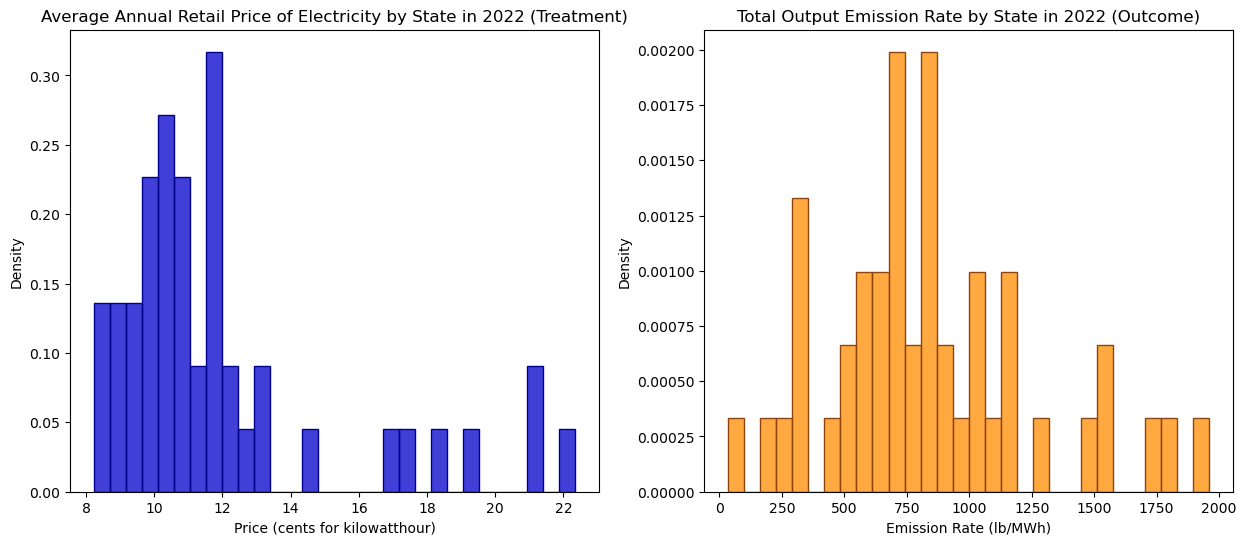

<Figure size 640x480 with 0 Axes>

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(total['Electricity Price (cents/kWh)'], stat='density', bins=30, ax=axes[0], 
             color='mediumblue', edgecolor='darkblue')
axes[0].set_title('Average Annual Retail Price of Electricity by State in 2022 (Treatment)')
axes[0].set_xlabel('Price (cents for kilowatthour)')

sns.histplot(total['CO2 (lb/MWh)'], stat='density', bins=30, ax=axes[1], 
             color='darkorange', edgecolor='saddlebrown')
axes[1].set_title('Total Output Emission Rate by State in 2022 (Outcome)')
axes[1].set_xlabel('Emission Rate (lb/MWh)')

plt.show()
plt.savefig("../can/distribution-treatment-outcome.png");

# Pair-wise Plots between Outcome, Treatment, and Confounders

## Categorize Confounders ##

- **Geographical**
  - Size of the State (acres)
  - [Farmland covarege in the State (acres)]
  - State Population
  - Percent of Urbanized Population
  - Water Percentage
- **Weather**
  - Average Annual Temperature ($F$)
  - Average Annual Precipitation ($in$)
  - Average Annual Sunlight Exposure ($kJ/m^2$)
  - [HDD/CDD]
- **Usage**
  - Consumption of Electricity by State
  - Production of Electricity by State (thousand $MWh$)
    - Renewable Sources
    - Non-renawble Sources
  - [Fuel Price]
  - Number of Power Plants
- **Policy**
  - 2020 Election Results (Presidential)
  - [Number of Clean Energy Policies]

## Geographical

In [129]:
total.iloc[:, list(range(0, 3)) + list(range(6, 8)) + list(range(14, 16))].head()

,State,Electricity Price (cents/kWh),CO2 (lb/MWh),Urban Population,Urban Population (%),total area (mile^2),water percentage
0,Maine,17.44,336.612,526309.0,38.6,"35,380",12.80%
1,Massachusetts,21.27,851.739,6416895.0,91.3,"10,554",26.10%
2,New Hampshire,21.07,302.928,803420.0,58.3,"9,349",4.20%
3,Rhode Island,19.30,811.317,999191.0,91.1,"1,545",33.10%
4,Vermont,16.99,35.627,225850.0,35.1,"9,616",4.20%


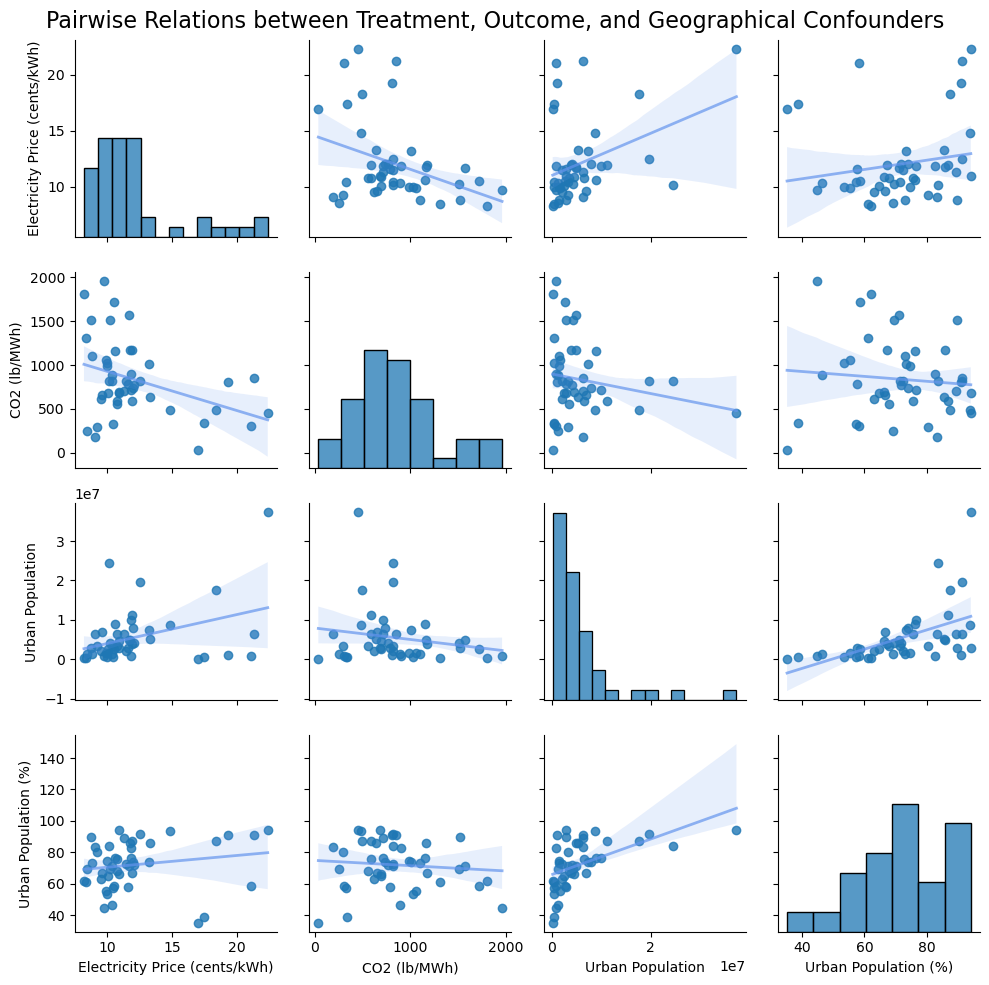

<Figure size 640x480 with 0 Axes>

In [151]:
g = sns.pairplot(total.iloc[:, list(range(0, 3)) + list(range(6, 8)) + list(range(14, 16))], diag_kind='hist', 
             kind='reg', plot_kws={'line_kws': {'color': 'cornflowerblue', 'linewidth': 2, 'alpha': 0.7}})
g.fig.suptitle('Pairwise Relations between Treatment, Outcome, and Geographical Confounders', size=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
plt.show()
plt.savefig("../can/pairwise-geographical.png");

## Weather

In [127]:
total.iloc[:, list(range(0, 3)) + list(range(8, 11))].head()

,State,Electricity Price (cents/kWh),CO2 (lb/MWh),avg annual temp (F),avg annual precip (in),avg annual sunlight (kJ/m^2)
0,Maine,17.44,336.612,41.0,45.5,3815.0
1,Massachusetts,21.27,851.739,47.9,48.6,3944.0
2,New Hampshire,21.07,302.928,43.8,47.9,3891.0
3,Rhode Island,19.30,811.317,50.1,49.1,3989.0
4,Vermont,16.99,35.627,42.9,46.0,3826.0


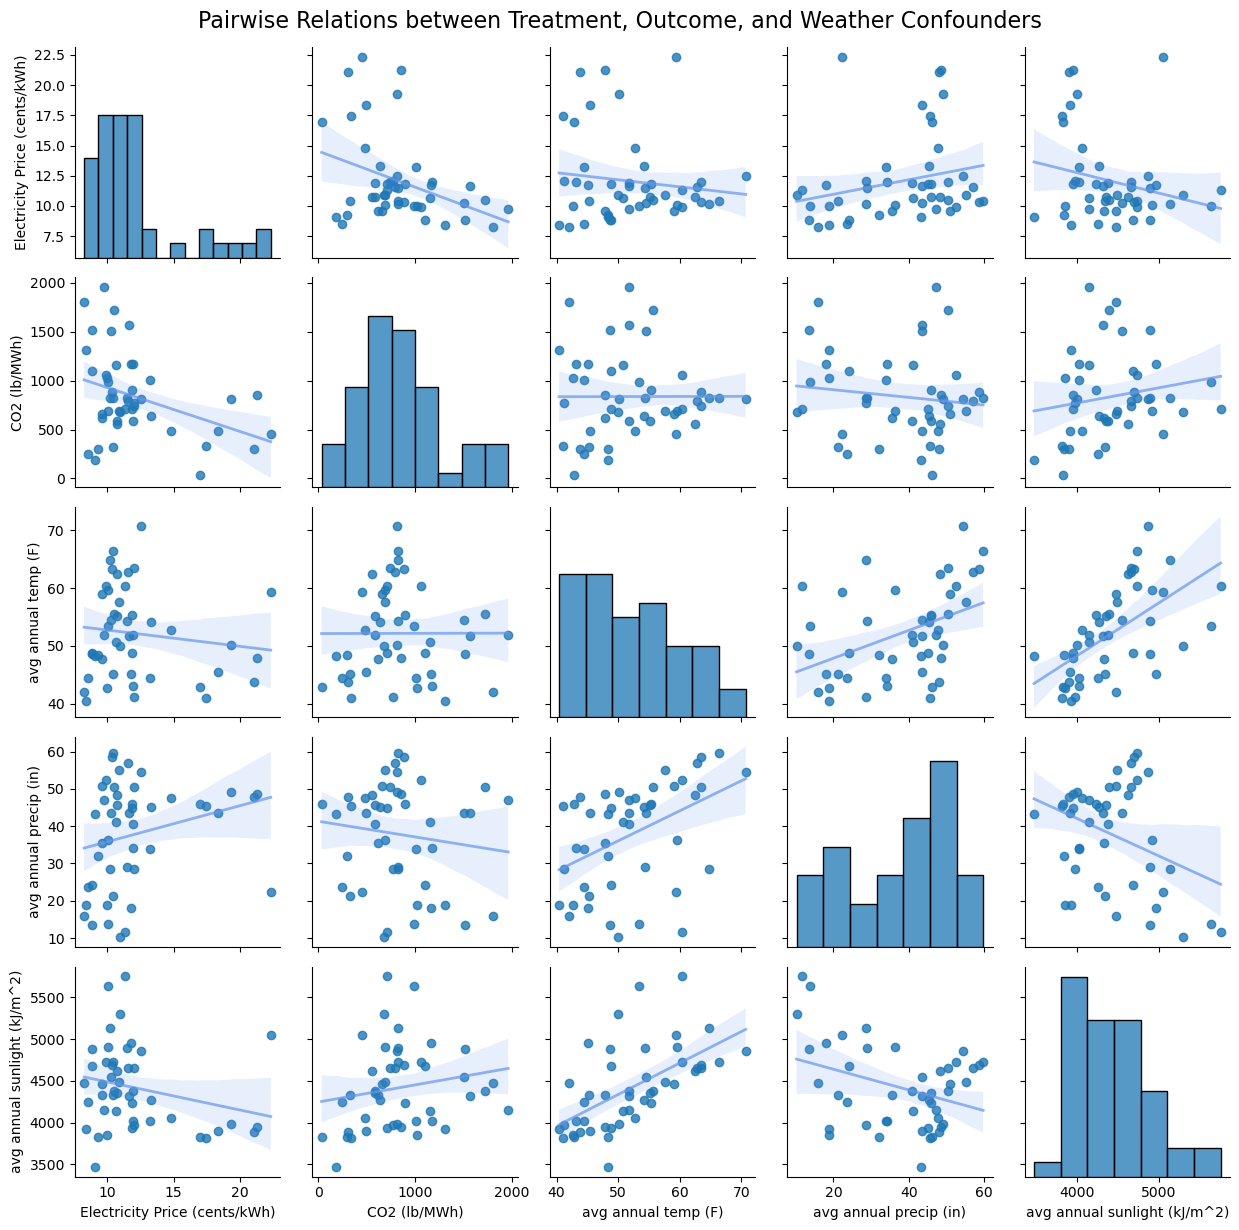

<Figure size 640x480 with 0 Axes>

In [150]:
g = sns.pairplot(total.iloc[:, list(range(0, 3)) + list(range(8, 11))], diag_kind='hist', 
             kind='reg', plot_kws={'line_kws': {'color': 'cornflowerblue', 'linewidth': 2, 'alpha': 0.7}})
g.fig.suptitle('Pairwise Relations between Treatment, Outcome, and Weather Confounders', size=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
plt.show()
plt.savefig("../can/pairwise-geographical.png");

## Usage

In [157]:
usage = total.loc[:, ['State', 'Electricity Price (cents/kWh)', 'CO2 (lb/MWh)','total nonrenewable prod (thousand MWh)',
       'total renewable prod (thousand MWh)','total consumption', 'num_plants']]

In [ ]:
g = sns.pairplot(usage, diag_kind='hist', 
             kind='reg', plot_kws={'line_kws': {'color': 'cornflowerblue', 'linewidth': 2, 'alpha': 0.7}})
g.fig.suptitle('Pairwise Relations between Treatment, Outcome, and Usage Confounders', size=16)

g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95, left=0.1, right=0.9, bottom=0.1)
plt.show()
plt.savefig("../can/pairwise-usage.png");

## Policy